# In this notebook we test out the linear regresion model with regularizations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from joblib import Memory
import scipy.stats as st

# Import necessary modules for modeling and preprocessing
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet


In [ ]:
train_file = r"C:\Users\malli\Documents\GitHub\Big-Mart-Sales-Prediction-Practice-Problem--\Datasets\train_cleaned_FE.csv"
df = pd.read_csv(train_file)
df = df.drop(columns=['MRP_by_Outlet_Type'])

In [3]:
categorical_cols = ['Item', 'Outlet', 'Outlet_Type','Outlet_Location_Type', 'Outlet_Size', 'Item_Fat_Content', 'Item_Type']
numerical_cols = ['Item_MRP', 'Item_Weight', 'Item_Visibility','Years_Since_Establishment', 
                  'Mean_Sales_Outlet_Type', 'Avg_Sales_by_Location_Type']

In [6]:
numerical_cols = [col for col in numerical_cols if col in df.columns]
categorical_cols = [col for col in categorical_cols if col in df.columns]


In [7]:
X = df.drop(columns=['Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']


In [8]:
# Ensure numerical_cols and categorical_cols match current dataframe
numerical_cols = [col for col in numerical_cols if col in df.columns]
categorical_cols = [col for col in categorical_cols if col in df.columns]
print("Columns in X:", X.columns)
print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Columns in X: Index(['Item', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet', 'Years_Since_Establishment',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Mean_Sales_Outlet_Type', 'Avg_Sales_by_Location_Type'],
      dtype='object')
Numerical Columns: ['Item_MRP', 'Item_Weight', 'Item_Visibility', 'Years_Since_Establishment', 'Mean_Sales_Outlet_Type', 'Avg_Sales_by_Location_Type']
Categorical Columns: ['Item', 'Outlet', 'Outlet_Type', 'Outlet_Location_Type', 'Outlet_Size', 'Item_Fat_Content', 'Item_Type']


In [5]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [9]:
memory = Memory(location='cache_dir', verbose=0)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
], memory=memory)

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
    ('scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False))
])
    
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [10]:
ridge_params = {
    'model__alpha': st.loguniform(1e-4, 1e2),
    'preprocessor__num__poly__degree': [1, 2]
}

lasso_params = {
    'model__alpha': st.loguniform(1e-4, 1e2),
    'preprocessor__num__poly__degree': [1, 2]
}

elasticnet_params = {
    'model__alpha': st.loguniform(1e-4, 1e2),
    'model__l1_ratio': st.uniform(0, 1),
    'preprocessor__num__poly__degree': [1, 2]
}


In [11]:
def tune_model(model, param_distributions, X, y, preprocessor, n_iter=10, cv=5, random_state=42):
    """
    Build a pipeline with the preprocessor and the given model,
    perform randomized search cross-validation, and return the best estimator.
    """
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ], memory=memory)
    
    rsearch = RandomizedSearchCV(
        pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring=rmse_scorer,
        random_state=random_state,
        n_jobs=-1,
        verbose=1
    )
    rsearch.fit(X, y)
    print(f"Best params for {model.__class__.__name__}: {rsearch.best_params_}")
    print(f"Best CV RMSE for {model.__class__.__name__}: {-rsearch.best_score_:.4f}")
    return rsearch.best_estimator_


In [12]:
best_models = {}

print("Tuning Ridge Regression...")
best_models['ridge'] = tune_model(Ridge(random_state=42), ridge_params, X, y, preprocessor)

print("Tuning Lasso Regression...")
# Increase max_iter to help convergence for Lasso.
best_models['lasso'] = tune_model(Lasso(random_state=42, max_iter=10000), lasso_params, X, y, preprocessor)

print("Tuning ElasticNet Regression...")
# Increase max_iter to help convergence for ElasticNet.
best_models['elasticnet'] = tune_model(ElasticNet(random_state=42, max_iter=10000), elasticnet_params, X, y, preprocessor)

Tuning Ridge Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for Ridge: {'model__alpha': 9.877700294007917, 'preprocessor__num__poly__degree': 2}
Best CV RMSE for Ridge: 1084.5610
Tuning Lasso Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for Lasso: {'model__alpha': 9.877700294007917, 'preprocessor__num__poly__degree': 2}
Best CV RMSE for Lasso: 1074.9226
Tuning ElasticNet Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for ElasticNet: {'model__alpha': 0.0012601639723276807, 'model__l1_ratio': 0.3042422429595377, 'preprocessor__num__poly__degree': 2}
Best CV RMSE for ElasticNet: 1093.3321


In [13]:
for name, model in best_models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring=rmse_scorer, n_jobs=-1)
    mean_rmse = -np.mean(scores)
    print(f"{name} model CV RMSE: {mean_rmse:.4f}")

ridge model CV RMSE: 1084.5610
lasso model CV RMSE: 1074.9226
elasticnet model CV RMSE: 1093.3321


In [14]:
test_file = r"C:\Users\malli\Documents\GitHub\Big-Mart-Sales-Prediction-Practice-Problem--\Datasets\test_cleaned_FE.csv"
test_data = pd.read_csv(test_file)
test_data = test_data.drop(columns=['MRP_by_Outlet_Type'],
                              errors='ignore')

# Choosing the best models based on CV RMSE
best_model_ridge = best_models['lasso']
predictions_ridge = best_model_ridge.predict(test_data)
test_data['Predicted_Item_Outlet_Sales_ridge'] = predictions_ridge
test_data['Predicted_Item_Outlet_Sales_ridge_abs'] = np.abs(predictions_ridge)

best_model_lasso = best_models['ridge']
predictions_lasso = best_model_lasso.predict(test_data)
test_data['Predicted_Item_Outlet_Sales_lasso'] = predictions_lasso
test_data['Predicted_Item_Outlet_Sales_lasso_abs'] = np.abs(predictions_lasso)

best_model_elasticnet = best_models['elasticnet']
predictions_elasticnet = best_model_elasticnet.predict(test_data)
test_data['Predicted_Item_Outlet_Sales_elasticnet'] = predictions_elasticnet
test_data['Predicted_Item_Outlet_Sales_elasticnet_abs'] = np.abs(predictions_elasticnet)


output_file = r"I:\My Drive\Data Science\Case Comps\Feburary Internship Retail Prediction\submissons\Regularized_Linear_Models_max_features.csv"
test_data.to_csv(output_file, index=False)
print("Predictions saved to:", output_file)


Predictions saved to: I:\My Drive\Data Science\Case Comps\Feburary Internship Retail Prediction\submissons\Regularized_Linear_Models_max_features.csv


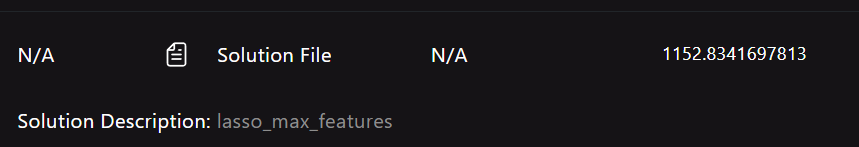

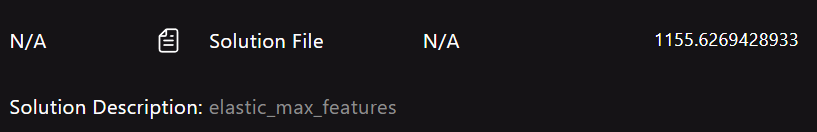

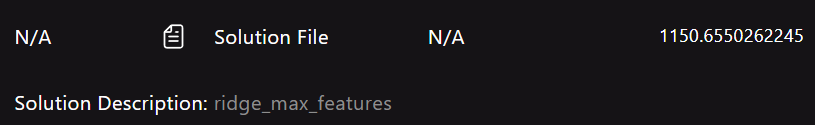

# We can see that **Ridge Regression provides the best result** which suggests that few features might be irrelevant.

In [15]:
import joblib
# Saving the trained ridge  model
model_path = r"C:\Users\malli\Documents\GitHub\Big-Mart-Sales-Prediction-Practice-Problem--\Saved Models\ridge_max_features.pkl"
with open(model_path, "wb") as f:
    joblib.dump(best_model_elasticnet, f)